# Engagement by account for DVR

### Jira: https://agrium.atlassian.net/browse/DA-1093

### Kris Matson
### 24 Oct 2019

### Purpose

Calculate engagement summaries for portal usage from CMDM and Google Big Query for joining to sales data by account id for DVR calculations

Data sets:
- 20191022-portal-users.txt: CMDM portal user data as of 2019 oct 22
- 20191023-bq-results-portal usage.csv: GA BQ data for user engagement

In [1]:
import numpy as np
import pandas as pd
import xlrd
import os
import seaborn as sns

# set global for os
if os.name == 'posix':
    mac = True
else:
    mac = False

# source data are flatfiles
# TODO: stabilize path names for transition to version ctrl
if mac == False:
    df_path = r"C:\Users\kmatson.AGRIUM\iCloudDrive\Documents\nutrien-digital\ir_metrics"
else:
    df_path = r"/Users/ma9558996/Documents/DVR-Metrics-Data"  
    
# read the data and return source df
def read_excel_data(path_name, xl_name, xlsheet_name):
    print("reading excel file: {} ...".format(xl_name))
    return pd.read_excel(os.path.join(path_name, xl_name), sheet_name=xlsheet_name)

In [2]:
# MDM data
# 
# portal user data as of 2019 oct 22
# flat file pulled from MDM using standard query
# TODO: check in standard query
src_file = r"20191022-portal-users.txt"
cust_df = pd.read_csv(os.path.join(df_path, src_file), sep='\t')
cust_df['CREATED_DT'] = pd.to_datetime(cust_df['CREATED_DT'])

# match on strings not ints to ensure avoid pandas type conversions to float!
cust_df['PERSON_EID'] = cust_df['PERSON_EID'].astype(str)
cust_df['ADMIN_CONTRACT_ID'] = cust_df['ADMIN_CONTRACT_ID'].astype(str)

cust_df.head()

,EMAIL,PERSON_EID,FIRST_NAME,LAST_NAME,ORG_EID,ORG_NAME,ADMIN_CONTRACT_ID,CREATED_DT
0,adam@baldwinag.com,422752096433493801,Adam,Baldwin,422952096433626701,Baldwin Ag,1226470,2018-03-13 18:05:33
1,adam@baldwinag.com,422752096433493801,Adam,Baldwin,422952096433626701,Baldwin Ag,1226494,2018-03-13 18:05:33
2,bauder.farms@zoho.com,568252096434238601,Darren,Bauder,564452096434248801,"Bauder Farms, LLC",1227622,2018-03-13 18:05:42
3,blazeforkfarms@yahoo.com,439952096434290901,Brian,Bretz,439052096434299901,Blazefork Farms LLC,1315232,2018-03-13 18:05:42
4,brewster167@gmail.com,729752096434336801,Andrew,Lewis,725952096434341701,A. J. Lewis farms,1706616,2018-03-13 18:05:43


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39971 entries, 0 to 39970
Data columns (total 8 columns):
EMAIL                39971 non-null object
PERSON_EID           39971 non-null object
FIRST_NAME           39971 non-null object
LAST_NAME            39971 non-null object
ORG_EID              39971 non-null int64
ORG_NAME             39971 non-null object
ADMIN_CONTRACT_ID    39971 non-null object
CREATED_DT           39971 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.4+ MB


In [4]:
# BQ data
# 20191023-bq-results-portal usage.csv
# TODO: check in google big query query for this usage case
src_file = r"20191023-bq-results-portal usage.csv"
ga_df = pd.read_csv(os.path.join(df_path, src_file))
# data type conversions as above
ga_df['earliest_visit_date'] = pd.to_datetime(ga_df['earliest_visit_date'])
ga_df['latest_visit_date'] = pd.to_datetime(ga_df['latest_visit_date'])
ga_df['userId'] = ga_df['userId'].astype(str)

ga_df.head()

,userId,num_visits,earliest_visit_date,latest_visit_date
0,293556501164074201,931,2019-08-05,2019-10-22
1,972555184373180802,640,2019-03-05,2019-10-22
2,198454169514158101,454,2018-11-08,2019-10-21
3,238853779755512101,395,2018-09-24,2019-10-18
4,987954221496356601,362,2018-11-14,2019-10-18


In [5]:
ga_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33164 entries, 0 to 33163
Data columns (total 4 columns):
userId                 33164 non-null object
num_visits             33164 non-null int64
earliest_visit_date    33164 non-null datetime64[ns]
latest_visit_date      33164 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 1.0+ MB


Merge these data sets to support the data format needed for DVR calculations:
```
idx	hh_id	acct_id	person_return_visits	hh_engaged	is_digital
0	AH_1001004	1001004	1	False	True
1	AH_1001008	1001008	2	True	True
2	AH_1001014	1001014	26	True	True
3	AH_1001057	1001057	13	True	True
4	AH_1001132	1001132	4	True	True
```

In [6]:
# TODO: logical verification that this results in the correct cardinality for the two source datasets

cust_ga_df = cust_df.merge(ga_df, left_on='PERSON_EID', right_on='userId', how='outer', indicator=True)
cust_ga_df.head()

,EMAIL,PERSON_EID,FIRST_NAME,LAST_NAME,ORG_EID,ORG_NAME,ADMIN_CONTRACT_ID,CREATED_DT,userId,num_visits,earliest_visit_date,latest_visit_date,_merge
0,adam@baldwinag.com,422752096433493801,Adam,Baldwin,4.229521e+17,Baldwin Ag,1226470,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,both
1,adam@baldwinag.com,422752096433493801,Adam,Baldwin,4.229521e+17,Baldwin Ag,1226494,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,both
2,bauder.farms@zoho.com,568252096434238601,Darren,Bauder,5.644521e+17,"Bauder Farms, LLC",1227622,2018-03-13 18:05:42,568252096434238601,74.0,2018-08-08,2019-10-10,both
3,blazeforkfarms@yahoo.com,439952096434290901,Brian,Bretz,4.390521e+17,Blazefork Farms LLC,1315232,2018-03-13 18:05:42,439952096434290901,4.0,2018-09-07,2019-10-21,both
4,brewster167@gmail.com,729752096434336801,Andrew,Lewis,7.259521e+17,A. J. Lewis farms,1706616,2018-03-13 18:05:43,729752096434336801,12.0,2018-10-05,2019-10-21,both


In [7]:
# look at non-matches
# TODO: check the cardinality is as expected
print('GA users without matching CMDM records: {}'.format(cust_ga_df[cust_ga_df['_merge'] == 'right_only'].userId.nunique()))
print('CMDM users without matching GA records: {}'.format(cust_ga_df[cust_ga_df['_merge'] == 'left_only'].userId.nunique()))
print('GA users with matching CMDM records:    {}'.format(cust_ga_df[cust_ga_df['_merge'] == 'both'].userId.nunique()))
print('Portal (CMDM) users:                    {}'.format(cust_df.PERSON_EID.nunique()))

# yikes wtf is going on here?
# TODO: check with Steve M and Jake

GA users without matching CMDM records: 4400
CMDM users without matching GA records: 0
GA users with matching CMDM records:    28764
Portal (CMDM) users:                    29579


In [8]:
# create engagement definitions

# everyone in this data set is digital
cust_ga_df['is_digital'] = True
34
# only num_visits >= 3 are engaged by DVR definition
cust_ga_df['hh_engaged'] = cust_ga_df['num_visits'] >= 3.0

cust_ga_df['hh_id'] = "AH_" + cust_ga_df['ADMIN_CONTRACT_ID']

# get the hh_id from concat with acct id
cust_ga_strip_df = cust_ga_df.drop(['EMAIL', 'FIRST_NAME','LAST_NAME','ORG_EID','PERSON_EID','_merge'], axis=1).copy()

In [9]:
# strip some columns
cust_ga_strip_df.head()

,ORG_NAME,ADMIN_CONTRACT_ID,CREATED_DT,userId,num_visits,earliest_visit_date,latest_visit_date,is_digital,hh_engaged,hh_id
0,Baldwin Ag,1226470,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,True,True,AH_1226470
1,Baldwin Ag,1226494,2018-03-13 18:05:33,422752096433493801,51.0,2018-08-20,2019-09-24,True,True,AH_1226494
2,"Bauder Farms, LLC",1227622,2018-03-13 18:05:42,568252096434238601,74.0,2018-08-08,2019-10-10,True,True,AH_1227622
3,Blazefork Farms LLC,1315232,2018-03-13 18:05:42,439952096434290901,4.0,2018-09-07,2019-10-21,True,True,AH_1315232
4,A. J. Lewis farms,1706616,2018-03-13 18:05:43,729752096434336801,12.0,2018-10-05,2019-10-21,True,True,AH_1706616


In [10]:
# uncomment to pickle if desired
# cust_ga_strip_df.to_pickle(os.path.join(df_path, "201910-cust-engagement.pickle"))

In [12]:
# get the sales data
import pickle
# read pickle file and output
# there is no conversion of the output
def un_pickle(pkl_fname):
    with open(pkl_fname, 'rb') as handle:
        result = pickle.load(handle)
    return result

all_inv_df = un_pickle(os.path.join(df_path, "all_inv_df.pickle"))
all_inv_df.head()

,Invoice Date,OrderSource,General Ledger Shelf,Sum of Net Sales,Customer ID,Country
0,2018-10-01,ARS,APPL,0.0,1001281.0,USA
1,2018-10-01,ARS,APPL,0.0,1004702.0,USA
2,2018-10-01,ARS,APPL,167.1,1005222.0,USA
3,2018-10-01,ARS,APPL,315.0,1005291.0,USA
4,2018-10-01,ARS,APPL,938.2,1006087.0,USA


In [13]:
# aberrant naming fix
all_inv_df = all_inv_df.rename(columns={'General Ledger Shelf ':'General Ledger Shelf'})

# fill these nulls
all_inv_df['General Ledger Shelf'] = all_inv_df['General Ledger Shelf'].fillna('OTHN')
all_inv_df[all_inv_df['General Ledger Shelf'].isnull()]
all_inv_df.isna().sum()

Invoice Date            0
OrderSource             0
General Ledger Shelf    0
Sum of Net Sales        0
Customer ID             1
Country                 0
dtype: int64

In [14]:
# only one NaN so brute force drop 
all_inv_df = all_inv_df.dropna()
all_inv_df.isna().any() == True

Invoice Date            False
OrderSource             False
General Ledger Shelf    False
Sum of Net Sales        False
Customer ID             False
Country                 False
dtype: bool

In [15]:
all_inv_df['Customer ID'] = all_inv_df['Customer ID'].astype(int).astype(str)
all_inv_df.head()

,Invoice Date,OrderSource,General Ledger Shelf,Sum of Net Sales,Customer ID,Country
0,2018-10-01,ARS,APPL,0.0,1001281,USA
1,2018-10-01,ARS,APPL,0.0,1004702,USA
2,2018-10-01,ARS,APPL,167.1,1005222,USA
3,2018-10-01,ARS,APPL,315.0,1005291,USA
4,2018-10-01,ARS,APPL,938.2,1006087,USA


In [16]:
# tie in engagement
eng_all_inv_df = all_inv_df.merge(cust_ga_strip_df, left_on='Customer ID', right_on='ADMIN_CONTRACT_ID', how='left', indicator=True)

In [17]:
eng_all_inv_df.head()

,Invoice Date,OrderSource,General Ledger Shelf,Sum of Net Sales,Customer ID,Country,ORG_NAME,ADMIN_CONTRACT_ID,CREATED_DT,userId,num_visits,earliest_visit_date,latest_visit_date,is_digital,hh_engaged,hh_id,_merge
0,2018-10-01,ARS,APPL,0.0,1001281,USA,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,left_only
1,2018-10-01,ARS,APPL,0.0,1004702,USA,DENFELD ORCHARDS,1004702,2018-11-07 17:07:24,339654161044418901,3.0,2018-11-07,2018-12-05,True,True,AH_1004702,both
2,2018-10-01,ARS,APPL,167.1,1005222,USA,ALLEN FARMS INC,1005222,2018-12-12 18:33:06,537454463958608701,9.0,2018-12-12,2019-06-07,True,True,AH_1005222,both
3,2018-10-01,ARS,APPL,315.0,1005291,USA,Trico Farms,1005291,2018-04-14 05:19:47,309352368318800301,3.0,2018-11-30,2019-01-14,True,True,AH_1005291,both
4,2018-10-01,ARS,APPL,938.2,1006087,USA,NaN,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,left_only


In [18]:
# set is_digital and is_engaged = False for NaNs
eng_all_inv_df['is_digital'] = eng_all_inv_df['is_digital'].fillna(False)
eng_all_inv_df['hh_engaged'] = eng_all_inv_df['hh_engaged'].fillna(False)
eng_all_inv_df.head()

,Invoice Date,OrderSource,General Ledger Shelf,Sum of Net Sales,Customer ID,Country,ORG_NAME,ADMIN_CONTRACT_ID,CREATED_DT,userId,num_visits,earliest_visit_date,latest_visit_date,is_digital,hh_engaged,hh_id,_merge
0,2018-10-01,ARS,APPL,0.0,1001281,USA,NaN,NaN,NaT,NaN,NaN,NaT,NaT,False,False,NaN,left_only
1,2018-10-01,ARS,APPL,0.0,1004702,USA,DENFELD ORCHARDS,1004702,2018-11-07 17:07:24,339654161044418901,3.0,2018-11-07,2018-12-05,True,True,AH_1004702,both
2,2018-10-01,ARS,APPL,167.1,1005222,USA,ALLEN FARMS INC,1005222,2018-12-12 18:33:06,537454463958608701,9.0,2018-12-12,2019-06-07,True,True,AH_1005222,both
3,2018-10-01,ARS,APPL,315.0,1005291,USA,Trico Farms,1005291,2018-04-14 05:19:47,309352368318800301,3.0,2018-11-30,2019-01-14,True,True,AH_1005291,both
4,2018-10-01,ARS,APPL,938.2,1006087,USA,NaN,NaN,NaT,NaN,NaN,NaT,NaT,False,False,NaN,left_only


In [19]:
# add inv month and year
eng_all_inv_df['Invoice Year'] = eng_all_inv_df['Invoice Date'].dt.year
eng_all_inv_df['Invoice Month'] = eng_all_inv_df['Invoice Date'].dt.month
# set the fiscal period
eng_all_inv_df['fiscal_period'] = pd.to_datetime(eng_all_inv_df['Invoice Date'].dt.strftime('%Y-%m'))

In [20]:
# set friendly names for plotting
eng_all_inv_df = eng_all_inv_df.rename(columns={'OrderSource':'Order Source','is_digital':'Digital Customer'})

In [21]:
# friendly category for digitla customer bool
eng_all_inv_df['Customer Category'] = np.where(eng_all_inv_df['Digital Customer'] == True, 'Digital', 'Non-Digital')

In [22]:
# what is the relationship between num_visits and account value?
# pivot on account to get sum visits and sum account value
acct_eng_sls_df = pd.DataFrame(eng_all_inv_df.pivot_table(index=['Customer ID','Customer Category'], \
                     values=['Sum of Net Sales','num_visits'], aggfunc='sum').to_records())
acct_eng_sls_df.head()

,Customer ID,Customer Category,Sum of Net Sales,num_visits
0,1001004,Digital,29852.30,2.0
1,1001007,Non-Digital,130985.98,0.0
2,1001008,Digital,2929.00,16.0
3,1001014,Digital,145683.34,1568.0
4,1001029,Non-Digital,3333.53,0.0


In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

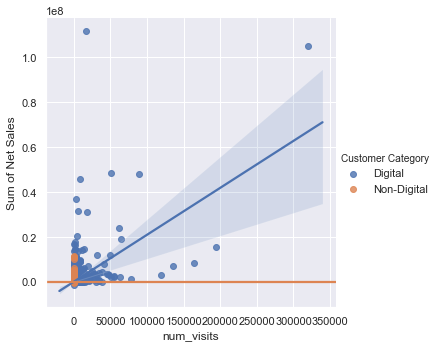

In [24]:
h = sns.lmplot(data=acct_eng_sls_df, x='num_visits', y='Sum of Net Sales', hue='Customer Category')
# control x and y limits
#h.set(xlim=(-10, 15000), ylim=(-10, 15000))
# nothing to learn here

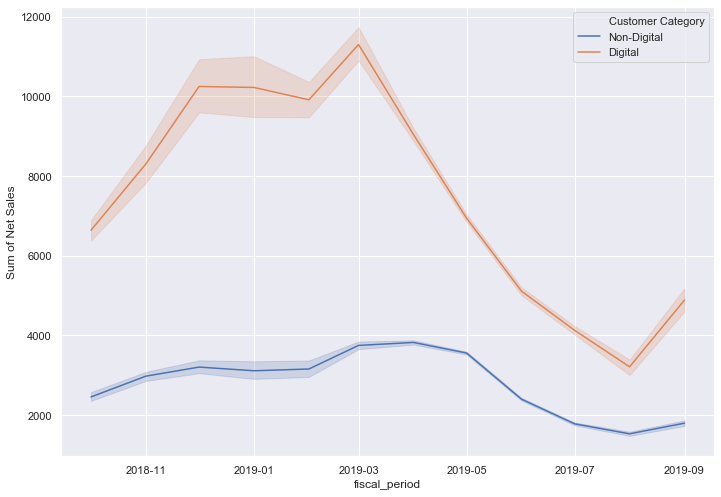

In [25]:
# average spend per month for digital customers is higher than for non-digital 
ax = sns.lineplot(x="fiscal_period", y="Sum of Net Sales", hue="Customer Category", \
                data=eng_all_inv_df)


[Text(0, 0.5, 'Average Sales Volume (USD)'),
 Text(0.5, 0, 'Year-Month'),
 Text(0.5, 1.0, 'Customer Average Sales Volume by Month')]

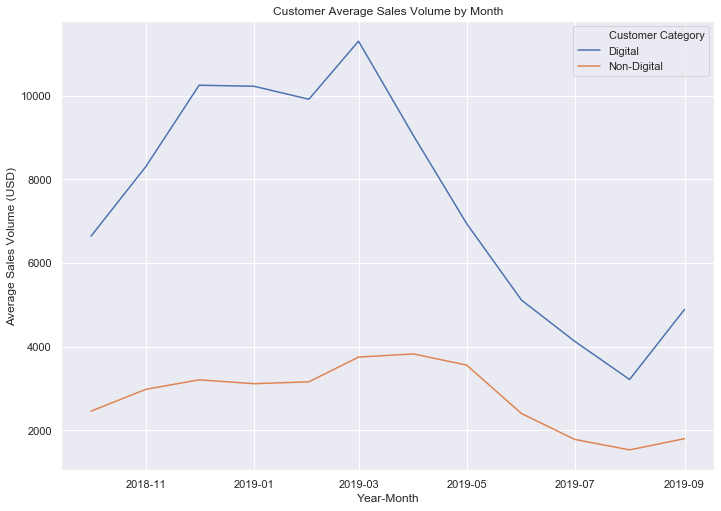

In [26]:
# get the average of the spend per month by is_digital
ax = sns.lineplot(x="fiscal_period", y="Sum of Net Sales", hue="Customer Category", \
                data=pd.DataFrame(eng_all_inv_df.pivot_table(index=['fiscal_period','Customer Category'], \
                     values=['Sum of Net Sales','num_visits'], aggfunc='mean').to_records()))

ax.set(xlabel='Year-Month', ylabel='Average Sales Volume (USD)', title='Customer Average Sales Volume by Month')

In [27]:
# pivot to get single series of the sum for each 
eng_all_inv_pvt_df = pd.DataFrame(eng_all_inv_df.pivot_table(index=['fiscal_period','Customer Category'], \
                     values=['Sum of Net Sales','num_visits'], aggfunc='sum').to_records())

[Text(0, 0.5, 'Total Sales Volume'),
 Text(0.5, 0, 'Year-Month'),
 Text(0.5, 1.0, 'Customer Total Sales Volume by Month')]

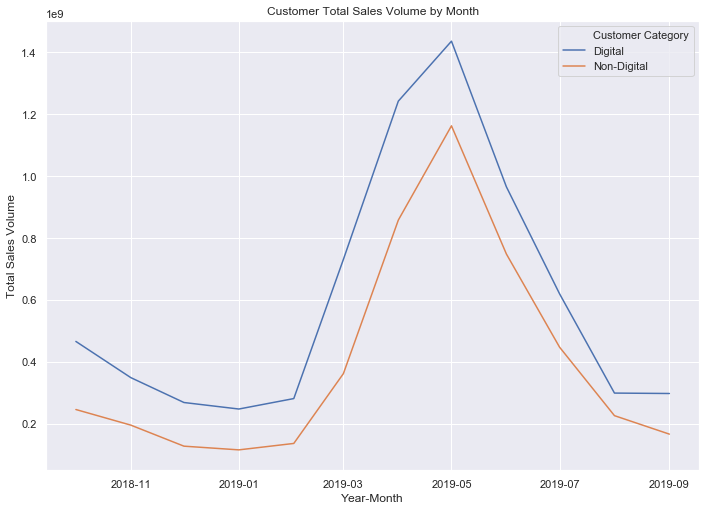

In [28]:
# total spend per month
ax = sns.lineplot(x="fiscal_period", y="Sum of Net Sales", hue='Customer Category', estimator=None, data=eng_all_inv_pvt_df)

# change titles
# Digital Customer
# Total Spend
# Year-Month
ax.set(xlabel='Year-Month', ylabel='Total Sales Volume', title='Customer Total Sales Volume by Month')


In [29]:
# what does digital spend look like as a percentage of total spend
tmp_digital_sales = eng_all_inv_pvt_df[eng_all_inv_pvt_df['Customer Category'] == 'Digital']
tmp_nondigital_sales = eng_all_inv_pvt_df[eng_all_inv_pvt_df['Customer Category'] == 'Non-Digital']
q418_q319_sales = tmp_digital_sales.merge(tmp_nondigital_sales, on='fiscal_period')
q418_q319_sales['Total Net Sales'] = (q418_q319_sales['Sum of Net Sales_x'] + q418_q319_sales['Sum of Net Sales_y'])
q418_q319_sales['Percent Digital Sales'] = 100 * (q418_q319_sales['Sum of Net Sales_x'] / q418_q319_sales['Total Net Sales'])
q418_q319_sales['Percent Non-Digital Sales'] = 100 * (q418_q319_sales['Sum of Net Sales_y'] / q418_q319_sales['Total Net Sales']) 
q418_q319_sales['Percent Digital Sales Increase'] = q418_q319_sales['Percent Digital Sales'] - q418_q319_sales['Percent Non-Digital Sales']

q418_q319_sales

,fiscal_period,Customer Category_x,Sum of Net Sales_x,num_visits_x,Customer Category_y,Sum of Net Sales_y,num_visits_y,Total Net Sales,Percent Digital Sales,Percent Non-Digital Sales,Percent Digital Sales Increase
0,2018-10-01,Digital,4.660865e+08,837517.0,Non-Digital,2.460937e+08,0.0,7.121803e+08,65.445022,34.554978,30.890044
1,2018-11-01,Digital,3.491603e+08,529449.0,Non-Digital,1.956895e+08,0.0,5.448498e+08,64.083770,35.916230,28.167539
2,2018-12-01,Digital,2.687518e+08,364544.0,Non-Digital,1.276883e+08,0.0,3.964401e+08,67.791283,32.208717,35.582565
3,2019-01-01,Digital,2.476862e+08,385995.0,Non-Digital,1.157341e+08,0.0,3.634204e+08,68.154195,31.845805,36.308390
4,2019-02-01,Digital,2.814731e+08,426403.0,Non-Digital,1.365054e+08,0.0,4.179785e+08,67.341527,32.658473,34.683054
5,2019-03-01,Digital,7.311893e+08,800150.0,Non-Digital,3.621358e+08,0.0,1.093325e+09,66.877576,33.122424,33.755152
6,2019-04-01,Digital,1.242423e+09,1413698.0,Non-Digital,8.581140e+08,0.0,2.100537e+09,59.147882,40.852118,18.295765
7,2019-05-01,Digital,1.436195e+09,1887583.0,Non-Digital,1.162700e+09,0.0,2.598895e+09,55.261744,44.738256,10.523489
8,2019-06-01,Digital,9.656473e+08,1730195.0,Non-Digital,7.485727e+08,0.0,1.714220e+09,56.331585,43.668415,12.663171
9,2019-07-01,Digital,6.201329e+08,1469173.0,Non-Digital,4.476651e+08,0.0,1.067798e+09,58.075863,41.924137,16.151726


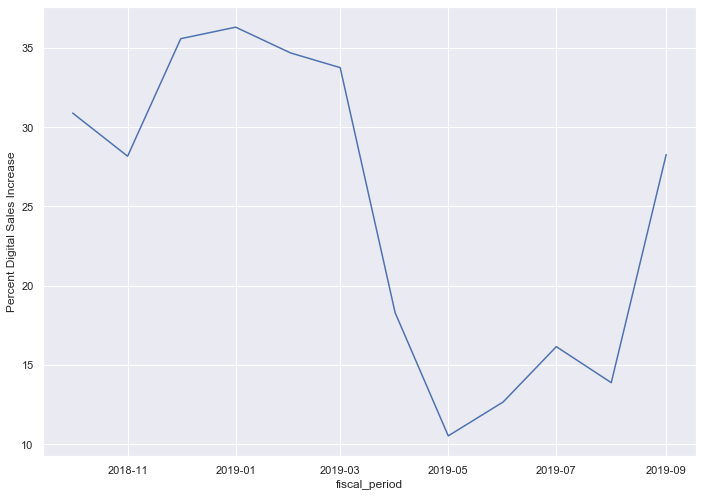

In [30]:
ax = sns.lineplot(x="fiscal_period", y="Percent Digital Sales Increase", estimator=None, data=q418_q319_sales)


[Text(0, 0.5, 'Average Customer Spend'),
 Text(0.5, 0, 'Year-Month'),
 Text(0.5, 1.0, 'Average Digital Customer Spend by Channel')]

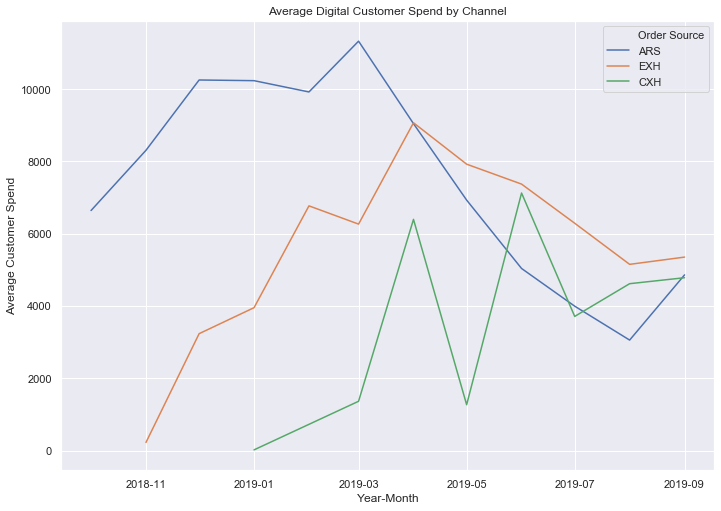

In [31]:
# average digital spend per month exceeded legacy system order size for digital customers 
temp_df = eng_all_inv_df[eng_all_inv_df["Customer Category"] == 'Digital']

ax = sns.lineplot(x="fiscal_period", y="Sum of Net Sales", hue="Order Source", \
                data=pd.DataFrame(temp_df.pivot_table(index=['fiscal_period','Order Source'], \
                                  values=['Sum of Net Sales','num_visits'], \
                                              aggfunc='mean').to_records()))

# change titles
# Average Spend per Customer (USD)
# Year-Month
# Order Source
ax.set(xlabel='Year-Month', ylabel='Average Customer Spend', title='Average Digital Customer Spend by Channel')

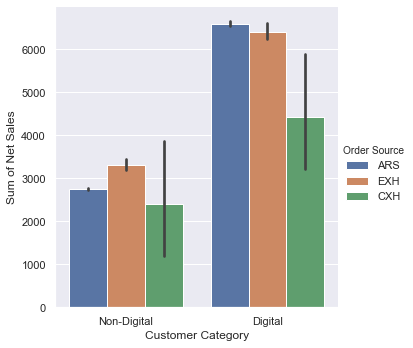

In [32]:
g = sns.catplot(x="Customer Category", y="Sum of Net Sales", hue="Order Source", kind="bar",\
            data=eng_all_inv_df);

In [33]:
dig_src_pvt_df = pd.DataFrame(eng_all_inv_df[eng_all_inv_df['Customer Category'] == 'Digital'].pivot_table(index=['fiscal_period','Order Source'], \
                     values=['Sum of Net Sales','num_visits'], aggfunc='sum').to_records())

[Text(0, 0.5, 'Customer Spend'),
 Text(0.5, 0, 'Year-Month'),
 Text(0.5, 1.0, 'Digital Customer Spend by Channel')]

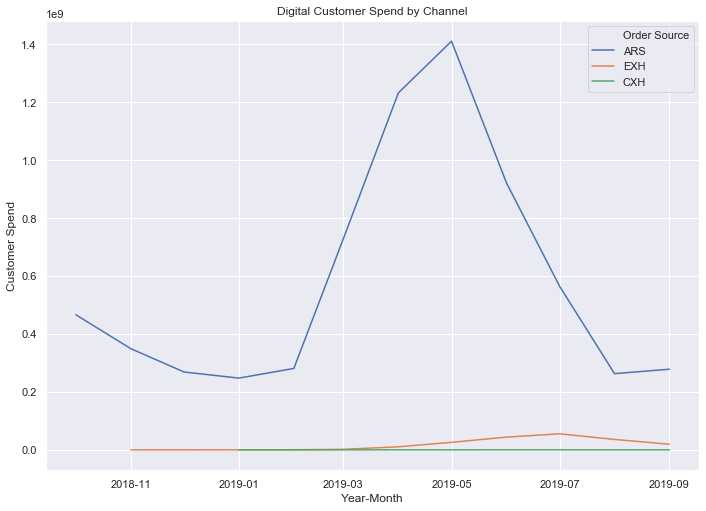

In [34]:
ax = sns.lineplot(x="fiscal_period", y="Sum of Net Sales", hue='Order Source', estimator=None, data=dig_src_pvt_df)

ax.set(xlabel='Year-Month', ylabel='Customer Spend', title='Digital Customer Spend by Channel')